In [1]:
import matplotlib
from datetime import datetime
from math import sin, cos, pi
import pandas as pd
import numpy as np
import boto3
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import pickle as pkl
from dotenv import load_dotenv, dotenv_values

import umap.umap_ as umap

In [2]:
pd.options.display.max_columns=100
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
config = dotenv_values(".env")# take environment variables from .env.
key = config['aws_key']
secret = config['aws_secret']

In [4]:
storage_options = { "key": key, "secret": secret}

In [5]:
%load_ext autotime

time: 178 µs (started: 2021-07-13 11:46:33 -07:00)


In [6]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

time: 430 µs (started: 2021-07-13 11:46:34 -07:00)


In [7]:
def plot_rates(data, label):
    fig,ax = plt.subplots(figsize=(18,7))
    sns.barplot(data=data, ax=ax)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(label)
    plt.tight_layout()
    plt.show()

time: 381 µs (started: 2021-07-13 11:46:36 -07:00)


# Herman Miller Customer Segmentation

This notebook will contain the feature transformations, modeling, and segment characterization required to generate segments for Herman Miller retail orders.

**RFM QUERY FOR SEGMENTATION**
```
COPY INTO 's3://hermanmiller/data/segmentation/rmf_2021_03_21/rfm_query.csv.gz'
FROM
(SELECT
    CAST(entity_id AS STRING) entity_id,
    CAST(nt_emails AS STRING) nt_emails,
    CAST(c_emails AS STRING) c_emails,
    CAST(shipaddress AS STRING) shipaddress,
    CAST(first_order AS STRING) first_order,
    CAST(CAST(first_order as DATE) AS STRING) first_order_date,
    CAST(DATE_PART('YEAR', first_order) AS STRING) first_order_year,
    CAST(last_order AS STRING) last_order,
    CAST(DATEDIFF('day', last_order, CURRENT_DATE()) AS STRING) recency,
    CAST(DIV0(num_orders,  DATEDIFF('day', first_order, last_order)) AS STRING) frequency,
    CAST(num_orders AS STRING) num_orders,
    CAST(total_revenue AS STRING) total_revenue,
    CAST(num_hm_orders_first_180_days AS STRING) num_hm_orders_first_180_days,
    CAST(num_dwr_orders_first_180_days AS STRING) num_dwr_orders_first_180_days,
    CAST(num_hay_orders_first_180_days AS STRING) num_hay_orders_first_180_days,
    CAST(hm_rev_first_180_days AS STRING) hm_rev_first_180_days,
    CAST(dwr_rev_first_180_days AS STRING) dwr_rev_first_180_days,
    CAST(hay_rev_first_180_days AS STRING) hay_rev_first_180_days,
    CAST(hm_items_bought_first_180_days AS STRING) hm_items_bought_first_180_days,
    CAST(dwr_items_bought_first_180_days AS STRING) dwr_items_bought_first_180_days,
    CAST(hay_items_bought_first_180_days AS STRING) hay_items_bought_first_180_days,
    CAST(Contract_orders_first_180_days AS STRING) Contract_orders_first_180_days,
    CAST(Corporate_orders_first_180_days AS STRING) Corporate_orders_first_180_days,
    CAST(Studio_orders_first_180_days AS STRING) Studio_orders_first_180_days,
    CAST(Wholesale_orders_first_180_days AS STRING) Wholesale_orders_first_180_days,
    CAST(HM_SF_Chestnut_orders_first_180_days AS STRING) HM_SF_Chestnut_orders_first_180_days,
    CAST(Call_Center_orders_first_180_days AS STRING) Call_Center_orders_first_180_days,
    CAST(Fabric_orders_first_180_days AS STRING) Fabric_orders_first_180_days,
    CAST(International_orders_first_180_days AS STRING) International_orders_first_180_days,
    CAST(Outlet_orders_first_180_days AS STRING) Outlet_orders_first_180_days,
    CAST(Warehouses_orders_first_180_days AS STRING) Warehouses_orders_first_180_days,
    CAST(Offsite_Inventory_orders_first_180_days AS STRING) Offsite_Inventory_orders_first_180_days,
    CAST(HM_Retail_orders_first_180_days AS STRING) HM_Retail_orders_first_180_days,
    CAST(Web_orders_first_180_days AS STRING) Web_orders_first_180_days,
    CAST(Contract_rev_first_180_days AS STRING) Contract_rev_first_180_days,
    CAST(Corporate_rev_first_180_days AS STRING) Corporate_rev_first_180_days,
    CAST(Studio_rev_first_180_days AS STRING) Studio_rev_first_180_days,
    CAST(Wholesale_rev_first_180_days AS STRING) Wholesale_rev_first_180_days,
    CAST(HM_SF_Chestnut_rev_first_180_days AS STRING) HM_SF_Chestnut_rev_first_180_days,
    CAST(Call_Center_rev_first_180_days AS STRING) Call_Center_rev_first_180_days,
    CAST(Fabric_rev_first_180_days AS STRING) Fabric_rev_first_180_days,
    CAST(International_rev_first_180_days AS STRING) International_rev_first_180_days,
    CAST(Outlet_rev_first_180_days AS STRING) Outlet_rev_first_180_days,
    CAST(Warehouses_rev_first_180_days AS STRING) Warehouses_rev_first_180_days,
    CAST(Offsite_Inventory_rev_first_180_days AS STRING) Offsite_Inventory_rev_first_180_days,
    CAST(HM_Retail_rev_first_180_days AS STRING) HM_Retail_rev_first_180_days,
    CAST(Web_rev_first_180_days AS STRING) Web_rev_first_180_days,
    CAST(num_hm_orders_after_first_180_days AS STRING) num_hm_orders_after_first_180_days,
    CAST(num_dwr_orders_after_first_180_days AS STRING) num_dwr_orders_after_first_180_days,
    CAST(num_hay_orders_after_first_180_days AS STRING) num_hay_orders_after_first_180_days,
    CAST(hm_rev_after_first_180_days AS STRING) hm_rev_after_first_180_days,
    CAST(dwr_rev_after_first_180_days AS STRING) dwr_rev_after_first_180_days,
    CAST(hay_rev_after_first_180_days AS STRING) hay_rev_after_first_180_days,
    CAST(hm_items_bought_after_first_180_days AS STRING) hm_items_bought_after_first_180_days,
    CAST(dwr_items_bought_after_first_180_days AS STRING) dwr_items_bought_after_first_180_days,
    CAST(hay_items_bought_after_first_180_days AS STRING) hay_items_bought_after_first_180_days,
    CAST(Contract_orders_after_first_180_days AS STRING) Contract_orders_after_first_180_days,
    CAST(Corporate_orders_after_first_180_days AS STRING) Corporate_orders_after_first_180_days,
    CAST(Studio_orders_after_first_180_days AS STRING) Studio_orders_after_first_180_days,
    CAST(Wholesale_orders_after_first_180_days AS STRING) Wholesale_orders_after_first_180_days,
    CAST(HM_SF_Chestnut_orders_after_first_180_days AS STRING) HM_SF_Chestnut_orders_after_first_180_days,
    CAST(Call_Center_orders_after_first_180_days AS STRING) Call_Center_orders_after_first_180_days,
    CAST(Fabric_orders_after_first_180_days AS STRING) Fabric_orders_after_first_180_days,
    CAST(International_orders_after_first_180_days AS STRING) International_orders_after_first_180_days,
    CAST(Outlet_orders_after_first_180_days AS STRING) Outlet_orders_after_first_180_days,
    CAST(Warehouses_orders_after_first_180_days AS STRING) Warehouses_orders_after_first_180_days,
    CAST(Offsite_Inventory_orders_after_first_180_days AS STRING) Offsite_Inventory_orders_after_first_180_days,
    CAST(HM_Retail_orders_after_first_180_days AS STRING) HM_Retail_orders_after_first_180_days,
    CAST(Web_orders_after_first_180_days AS STRING) Web_orders_after_first_180_days,
    CAST(Contract_rev_after_first_180_days AS STRING) Contract_rev_after_first_180_days,
    CAST(Corporate_rev_after_first_180_days AS STRING) Corporate_rev_after_first_180_days,
    CAST(Studio_rev_after_first_180_days AS STRING) Studio_rev_after_first_180_days,
    CAST(Wholesale_rev_after_first_180_days AS STRING) Wholesale_rev_after_first_180_days,
    CAST(HM_SF_Chestnut_rev_after_first_180_days AS STRING) HM_SF_Chestnut_rev_after_first_180_days,
    CAST(Call_Center_rev_after_first_180_days AS STRING) Call_Center_rev_after_first_180_days,
    CAST(Fabric_rev_after_first_180_days AS STRING) Fabric_rev_after_first_180_days,
    CAST(International_rev_after_first_180_days AS STRING) International_rev_after_first_180_days,
    CAST(Outlet_rev_after_first_180_days AS STRING) Outlet_rev_after_first_180_days,
    CAST(Warehouses_rev_after_first_180_days AS STRING) Warehouses_rev_after_first_180_days,
    CAST(Offsite_Inventory_rev_after_first_180_days AS STRING) Offsite_Inventory_rev_after_first_180_days,
    CAST(HM_Retail_rev_after_first_180_days AS STRING) HM_Retail_rev_after_first_180_days,
    CAST(Web_rev_after_first_180_days AS STRING) Web_rev_after_first_180_days,

    CAST(DIV0(hm_rev_first_180_days, num_hm_orders_first_180_days) AS STRING) hm_aov_first_180_days,
    CAST(DIV0(dwr_rev_first_180_days, num_dwr_orders_first_180_days) AS STRING) dwr_aov_first_180_days,
    CAST(DIV0(hay_rev_first_180_days, num_hay_orders_first_180_days) AS STRING) hay_aov_first_180_days,

    CAST(DIV0(hm_rev_after_first_180_days, num_hm_orders_after_first_180_days) AS STRING) hm_aov_after_first_180_days,
    CAST(DIV0(dwr_rev_after_first_180_days, num_dwr_orders_after_first_180_days) AS STRING) dwr_aov_after_first_180_days,
    CAST(DIV0(hay_rev_after_first_180_days, num_hay_orders_after_first_180_days) AS STRING) hay_aov_after_first_180_days

FROM
(SELECT
    entity_id entity_id,
    listagg(DISTINCT nt_email, ',') nt_emails,
    listagg(DISTINCT c_email, ',') c_emails,
    MAX(shipaddress) shipaddress,
    MIN(trandate) first_order,
    MAX(trandate) last_order,
    listagg(brand, ',') within group (order by trandate asc) brands,
    COUNT(DISTINCT transaction_id) num_orders,
    SUM(income_amount_usd) total_revenue,
    COUNT(DISTINCT CASE WHEN BRAND = 'Herman Miller' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN transaction_id ELSE NULL END ) num_hm_orders_first_180_days,
    COUNT(DISTINCT CASE WHEN BRAND = 'Design Within Reach' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN transaction_id ELSE NULL END ) num_dwr_orders_first_180_days,
    COUNT(DISTINCT CASE WHEN BRAND = 'HAY' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN transaction_id ELSE NULL END ) num_hay_orders_first_180_days,

    SUM(CASE WHEN BRAND = 'Herman Miller' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN income_amount_usd ELSE 0 END ) hm_rev_first_180_days,
    SUM(CASE WHEN BRAND = 'Design Within Reach' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN income_amount_usd ELSE 0 END ) dwr_rev_first_180_days,
    SUM(CASE WHEN BRAND = 'HAY' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN income_amount_usd ELSE 0 END ) hay_rev_first_180_days,

    SUM(CASE WHEN BRAND = 'Herman Miller' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN total_item_count ELSE 0 END ) hm_items_bought_first_180_days,
    SUM(CASE WHEN BRAND = 'Design Within Reach' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN total_item_count ELSE 0 END ) dwr_items_bought_first_180_days,
    SUM(CASE WHEN BRAND = 'HAY' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN total_item_count ELSE 0 END ) hay_items_bought_first_180_days,

    SUM(CASE WHEN channel='Contract' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180  
        THEN 1 ELSE 0 END) Contract_orders_first_180_days,
    SUM(CASE WHEN channel='Corporate' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN 1 ELSE 0 END) Corporate_orders_first_180_days,
    SUM(CASE WHEN channel='Studio' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN 1 ELSE 0 END) Studio_orders_first_180_days,
    SUM(CASE WHEN channel='Wholesale' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN 1 ELSE 0 END) Wholesale_orders_first_180_days,
    SUM(CASE WHEN channel='HM SF Chestnut St|354' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN 1 ELSE 0 END) HM_SF_Chestnut_orders_first_180_days,
    SUM(CASE WHEN channel='Call Center' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN 1 ELSE 0 END) Call_Center_orders_first_180_days,
    SUM(CASE WHEN channel='Fabric' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN 1 ELSE 0 END) Fabric_orders_first_180_days,
    SUM(CASE WHEN channel='International' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN 1 ELSE 0 END) International_orders_first_180_days,
    SUM(CASE WHEN channel='Outlet' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN 1 ELSE 0 END) Outlet_orders_first_180_days,
    SUM(CASE WHEN channel='Warehouses' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN 1 ELSE 0 END) Warehouses_orders_first_180_days,
    SUM(CASE WHEN channel='Offsite Inventory' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN 1 ELSE 0 END) Offsite_Inventory_orders_first_180_days,
    SUM(CASE WHEN channel='HM Retail' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN 1 ELSE 0 END) HM_Retail_orders_first_180_days,
    SUM(CASE WHEN channel='Web' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN 1 ELSE 0 END) Web_orders_first_180_days,

    SUM(CASE WHEN channel='Contract' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180  
        THEN income_amount_usd  ELSE 0 END) Contract_rev_first_180_days,
    SUM(CASE WHEN channel='Corporate' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN income_amount_usd  ELSE 0 END) Corporate_rev_first_180_days,
    SUM(CASE WHEN channel='Studio' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN income_amount_usd  ELSE 0 END) Studio_rev_first_180_days,
    SUM(CASE WHEN channel='Wholesale' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN income_amount_usd  ELSE 0 END) Wholesale_rev_first_180_days,
    SUM(CASE WHEN channel='HM SF Chestnut St|354' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN income_amount_usd  ELSE 0 END) HM_SF_Chestnut_rev_first_180_days,
    SUM(CASE WHEN channel='Call Center' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN income_amount_usd  ELSE 0 END) Call_Center_rev_first_180_days,
    SUM(CASE WHEN channel='Fabric' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN income_amount_usd  ELSE 0 END) Fabric_rev_first_180_days,
    SUM(CASE WHEN channel='International' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN income_amount_usd  ELSE 0 END) International_rev_first_180_days,
    SUM(CASE WHEN channel='Outlet' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN income_amount_usd  ELSE 0 END) Outlet_rev_first_180_days,
    SUM(CASE WHEN channel='Warehouses' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN income_amount_usd  ELSE 0 END) Warehouses_rev_first_180_days,
    SUM(CASE WHEN channel='Offsite Inventory' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN income_amount_usd  ELSE 0 END) Offsite_Inventory_rev_first_180_days,
    SUM(CASE WHEN channel='HM Retail' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN income_amount_usd  ELSE 0 END) HM_Retail_rev_first_180_days,
    SUM(CASE WHEN channel='Web' AND DATEDIFF('day', min_trandate, trandate) BETWEEN 0 AND 180 
        THEN income_amount_usd  ELSE 0 END) Web_rev_first_180_days,

    COUNT(DISTINCT CASE WHEN BRAND = 'Herman Miller' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN transaction_id ELSE NULL END ) num_hm_orders_after_first_180_days,
    COUNT(DISTINCT CASE WHEN BRAND = 'Design Within Reach' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN transaction_id ELSE NULL END ) num_dwr_orders_after_first_180_days,
    COUNT(DISTINCT CASE WHEN BRAND = 'HAY' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN transaction_id ELSE NULL END ) num_hay_orders_after_first_180_days,

    SUM(CASE WHEN BRAND = 'Herman Miller' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN income_amount_usd ELSE 0 END ) hm_rev_after_first_180_days,
    SUM(CASE WHEN BRAND = 'Design Within Reach' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN income_amount_usd ELSE 0 END ) dwr_rev_after_first_180_days,
    SUM(CASE WHEN BRAND = 'HAY' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN income_amount_usd ELSE 0 END ) hay_rev_after_first_180_days,

    SUM(CASE WHEN BRAND = 'Herman Miller' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN total_item_count ELSE 0 END ) hm_items_bought_after_first_180_days,
    SUM(CASE WHEN BRAND = 'Design Within Reach' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN total_item_count ELSE 0 END ) dwr_items_bought_after_first_180_days,
    SUM(CASE WHEN BRAND = 'HAY' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN total_item_count ELSE 0 END ) hay_items_bought_after_first_180_days,

    SUM(CASE WHEN channel='Contract' AND DATEDIFF('day', min_trandate, trandate) > 180 
        THEN 1 ELSE 0 END) Contract_orders_after_first_180_days,
    SUM(CASE WHEN channel='Corporate' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN 1 ELSE 0 END) Corporate_orders_after_first_180_days,
    SUM(CASE WHEN channel='Studio' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN 1 ELSE 0 END) Studio_orders_after_first_180_days,
    SUM(CASE WHEN channel='Wholesale' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN 1 ELSE 0 END) Wholesale_orders_after_first_180_days,
    SUM(CASE WHEN channel='HM SF Chestnut St|354' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN 1 ELSE 0 END) HM_SF_Chestnut_orders_after_first_180_days,
    SUM(CASE WHEN channel='Call Center' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN 1 ELSE 0 END) Call_Center_orders_after_first_180_days,
    SUM(CASE WHEN channel='Fabric' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN 1 ELSE 0 END) Fabric_orders_after_first_180_days,
    SUM(CASE WHEN channel='International' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN 1 ELSE 0 END) International_orders_after_first_180_days,
    SUM(CASE WHEN channel='Outlet' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN 1 ELSE 0 END) Outlet_orders_after_first_180_days,
    SUM(CASE WHEN channel='Warehouses' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN 1 ELSE 0 END) Warehouses_orders_after_first_180_days,
    SUM(CASE WHEN channel='Offsite Inventory' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN 1 ELSE 0 END) Offsite_Inventory_orders_after_first_180_days,
    SUM(CASE WHEN channel='HM Retail' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN 1 ELSE 0 END) HM_Retail_orders_after_first_180_days,
    SUM(CASE WHEN channel='Web' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN 1 ELSE 0 END) Web_orders_after_first_180_days,

    SUM(CASE WHEN channel='Contract' AND DATEDIFF('day', min_trandate, trandate) > 180 
        THEN income_amount_usd ELSE 0 END) Contract_rev_after_first_180_days,
    SUM(CASE WHEN channel='Corporate' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN income_amount_usd ELSE 0 END) Corporate_rev_after_first_180_days,
    SUM(CASE WHEN channel='Studio' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN income_amount_usd ELSE 0 END) Studio_rev_after_first_180_days,
    SUM(CASE WHEN channel='Wholesale' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN income_amount_usd ELSE 0 END) Wholesale_rev_after_first_180_days,
    SUM(CASE WHEN channel='HM SF Chestnut St|354' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN income_amount_usd ELSE 0 END) HM_SF_Chestnut_rev_after_first_180_days,
    SUM(CASE WHEN channel='Call Center' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN income_amount_usd ELSE 0 END) Call_Center_rev_after_first_180_days,
    SUM(CASE WHEN channel='Fabric' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN income_amount_usd ELSE 0 END) Fabric_rev_after_first_180_days,
    SUM(CASE WHEN channel='International' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN income_amount_usd ELSE 0 END) International_rev_after_first_180_days,
    SUM(CASE WHEN channel='Outlet' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN income_amount_usd ELSE 0 END) Outlet_rev_after_first_180_days,
    SUM(CASE WHEN channel='Warehouses' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN income_amount_usd ELSE 0 END) Warehouses_rev_after_first_180_days,
    SUM(CASE WHEN channel='Offsite Inventory' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN income_amount_usd ELSE 0 END) Offsite_Inventory_rev_after_first_180_days,
    SUM(CASE WHEN channel='HM Retail' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN income_amount_usd ELSE 0 END) HM_Retail_rev_after_first_180_days,
    SUM(CASE WHEN channel='Web' AND DATEDIFF('day', min_trandate, trandate) > 180
        THEN income_amount_usd ELSE 0 END) Web_rev_after_first_180_days
FROM
  (SELECT nt.transaction_id, 
          nt.entity_id, 
          nt.location_id,
          fc.fiscal_day trandate,
          nt.email nt_email, 
          le.list_item_name brand,
          pl.name channel,
          mt.min_trandate,
          SUM(case when collate(gl.ACCOUNTTYPE, 'en-ci') = 'Income' then ntl.AMOUNT * -1  * nt.EXCHANGE_RATE else 0 end) as income_amount_usd,
          SUM(case when collate(gl.ACCOUNTTYPE, 'en-ci') = 'Tax' then ntl.AMOUNT * -1  * nt.EXCHANGE_RATE else 0 end) as tax_amount_usd,
          SUM(case when collate(gl.ACCOUNTTYPE, 'en-ci') = 'Freight' then ntl.AMOUNT * -1 * nt.EXCHANGE_RATE else 0 end) as freight_amount_usd,
          SUM(case when collate(gl.ACCOUNTTYPE, 'en-ci') = 'Income' then ntl.ITEM_COUNT * -1 else 0 end) as total_item_count,
          MAX(c.shipaddress) shipaddress,
          MAX(c.email) c_email
  FROM "NORTHSTAR"."RAW"."NETSUITE_TRANSACTIONS" nt
  JOIN (SELECT  entity_id, MIN(trandate) min_trandate
        FROM "NORTHSTAR"."RAW"."NETSUITE_TRANSACTIONS"
        GROUP BY 1) mt
  ON nt.entity_id = mt.entity_id
  JOIN "NORTHSTAR"."RAW"."NETSUITE_TRANSACTION_LINES" ntl
      ON nt.transaction_id=ntl.transaction_id
  LEFT JOIN RAW.NETSUITE_CUSTOMERS c
      ON nt.entity_id = c.customer_id
  LEFT JOIN RAW.NETSUITE_ACCOUNTS a
      ON ntl.ACCOUNT_ID = a.ACCOUNT_ID 
  LEFT JOIN (select * from RAW.NETSUITE_GLAccountNumbers where SourceSystem_ID = 5)  gl
      ON a.accountnumber = gl.GLAccountNumber
  LEFT JOIN RAW.NETSUITE_LOCATIONS l
      ON l.location_id = nt.location_id
  LEFT JOIN RAW.NETSUITE_LOCATION_ENTITY le 
      ON l.location_entity_id = le.list_id
  LEFT JOIN "NORTHSTAR"."BO"."FISCAL_DAY_CALENDAR" fc
      ON nt.trandate = fc.fiscal_day
  LEFT JOIN ( SELECT * 
             FROM "NORTHSTAR"."RAW"."NETSUITE_LOCATIONS"
             WHERE parent_id IS NULL) pl
      ON l.parent_id = pl.location_id
  WHERE (nt.transaction_type = 'Sales Order' OR nt.transaction_type = 'Cash Sale')
  GROUP BY nt.transaction_id, nt.entity_id, mt.min_trandate, nt.location_id, fc.fiscal_day, nt.email, le.list_item_name,  pl.name) tl
GROUP BY entity_id) a)
FILE_FORMAT = (TYPE = 'CSV', FIELD_OPTIONALLY_ENCLOSED_BY='"')
SINGLE = TRUE
MAX_FILE_SIZE = 167772160
OVERWRITE = TRUE;
```

## Load Data

In [14]:
rfm_columns = ["entity_id",
"nt_emails",
"c_emails",
"shipaddress",
"first_order",
"first_order_date",
"first_order_year",
"last_order",
"recency",
"frequency",
"num_orders",
"total_revenue",
"num_hm_orders_first_180_days",
"num_dwr_orders_first_180_days",
"num_hay_orders_first_180_days",
"hm_rev_first_180_days",
"dwr_rev_first_180_days",
"hay_rev_first_180_days",
"hm_items_bought_first_180_days",
"dwr_items_bought_first_180_days",
"hay_items_bought_first_180_days",
"Contract_orders_first_180_days",
"Corporate_orders_first_180_days",
"Studio_orders_first_180_days",
"Wholesale_orders_first_180_days",
"HM_SF_Chestnut_orders_first_180_days",
"Call_Center_orders_first_180_days",
"Fabric_orders_first_180_days",
"International_orders_first_180_days",
"Outlet_orders_first_180_days",
"Warehouses_orders_first_180_days",
"Offsite_Inventory_orders_first_180_days",
"HM_Retail_orders_first_180_days",
"Web_orders_first_180_days",
"Contract_rev_first_180_days",
"Corporate_rev_first_180_days",
"Studio_rev_first_180_days",
"Wholesale_rev_first_180_days",
"HM_SF_Chestnut_rev_first_180_days",
"Call_Center_rev_first_180_days",
"Fabric_rev_first_180_days",
"International_rev_first_180_days",
"Outlet_rev_first_180_days",
"Warehouses_rev_first_180_days",
"Offsite_Inventory_rev_first_180_days",
"HM_Retail_rev_first_180_days",
"Web_rev_first_180_days",
"num_hm_orders_after_first_180_days",
"num_dwr_orders_after_first_180_days",
"num_hay_orders_after_first_180_days",
"hm_rev_after_first_180_days",
"dwr_rev_after_first_180_days",
"hay_rev_after_first_180_days",
"hm_items_bought_after_first_180_days",
"dwr_items_bought_after_first_180_days",
"hay_items_bought_after_first_180_days",
"Contract_orders_after_first_180_days",
"Corporate_orders_after_first_180_days",
"Studio_orders_after_first_180_days",
"Wholesale_orders_after_first_180_days",
"HM_SF_Chestnut_orders_after_first_180_days",
"Call_Center_orders_after_first_180_days",
"Fabric_orders_after_first_180_days",
"International_orders_after_first_180_days",
"Outlet_orders_after_first_180_days",
"Warehouses_orders_after_first_180_days",
"Offsite_Inventory_orders_after_first_180_days",
"HM_Retail_orders_after_first_180_days",
"Web_orders_after_first_180_days",
"Contract_rev_after_first_180_days",
"Corporate_rev_after_first_180_days",
"Studio_rev_after_first_180_days",
"Wholesale_rev_after_first_180_days",
"HM_SF_Chestnut_rev_after_first_180_days",
"Call_Center_rev_after_first_180_days",
"Fabric_rev_after_first_180_days",
"International_rev_after_first_180_days",
"Outlet_rev_after_first_180_days",
"Warehouses_rev_after_first_180_days",
"Offsite_Inventory_rev_after_first_180_days",
"HM_Retail_rev_after_first_180_days",
"Web_rev_after_first_180_days",
"hm_aov_first_180_days",
"dwr_aov_first_180_days",
"hay_aov_first_180_days",
"hm_aov_after_first_180_days",
"dwr_aov_after_first_180_days",
"hay_aov_after_first_180_days"]

email_columns=["email",
"first_send_date",
"first_engage_date",
"num_dwr_sends_first_180_days",
"num_hm_sends_first_180_days",
"num_hay_sends_first_180_days",
"num_dwr_opens_first_180_days",
"num_hm_opens_first_180_days",
"num_hay_opens_first_180_days",
"num_dwr_clicks_first_180_days",
"num_hm_clicks_first_180_days",
"num_hay_clicks_first_180_days",
"num_dwr_unsubs_first_180_days",
"num_hm_unsubs_first_180_days",
"num_hay_unsubs_first_180_days",
"num_dwr_spams_first_180_days",
"num_hm_spams_first_180_days",
"num_hay_spams_first_180_days",
"num_sale_sends_first_180_days",
"num_sale_opens_first_180_days",
"num_sale_clicks_first_180_days",
"num_evergreen_sends_first_180_days",
"num_evergreen_opens_first_180_days",
"num_evergreen_clicks_first_180_days",
"num_transactional_sends_first_180_days",
"num_transactional_opens_first_180_days",
"num_transactional_clicks_first_180_days",
"num_trigger_sends_first_180_days",
"num_trigger_opens_first_180_days",
"num_trigger_clicks_first_180_days",
"num_outlets_sends_first_180_days",
"num_outlets_opens_first_180_days",
"num_outlets_clicks_first_180_days",
"num_trade_sends_first_180_days",
"num_trade_opens_first_180_days",
"num_trade_clicks_first_180_days",
"num_contract_sends_first_180_days",
"num_contract_opens_first_180_days",
"num_contract_clicks_first_180_days",
"num_dwr_sends_after_first_180_days",
"num_hm_sends_after_first_180_days",
"num_hay_sends_after_first_180_days",
"num_dwr_opens_after_first_180_days",
"num_hm_opens_after_first_180_days",
"num_hay_opens_after_first_180_days",
"num_dwr_clicks_after_first_180_days",
"num_hm_clicks_after_first_180_days",
"num_hay_clicks_after_first_180_days",
"num_dwr_unsubs_after_first_180_days",
"num_hm_unsubs_after_first_180_days",
"num_hay_unsubs_after_first_180_days",
"num_sale_sends_after_first_180_days",
"num_sale_opens_after_first_180_days",
"num_sale_clicks_after_first_180_days",
"num_evergreen_sends_after_first_180_days",
"num_evergreen_opens_after_first_180_days",
"num_evergreen_clicks_after_first_180_days",
"num_transactional_sends_after_first_180_days",
"num_transactional_opens_after_first_180_days",
"num_transactional_clicks_after_first_180_days",
"num_trigger_sends_after_first_180_days",
"num_trigger_opens_after_first_180_days",
"num_trigger_clicks_after_first_180_days",
"num_outlets_sends_after_first_180_days",
"num_outlets_opens_after_first_180_days",
"num_outlets_clicks_after_first_180_days",
"num_trade_sends_after_first_180_days",
"num_trade_opens_after_first_180_days",
"num_trade_clicks_after_first_180_days",
"num_contract_sends_after_first_180_days",
"num_contract_opens_after_first_180_days",
"num_contract_clicks_after_first_180_days",
"num_dwr_sends_before_purchase",
"num_hm_sends_before_purchase",
"num_hay_sends_before_purchase",
"num_dwr_opens_before_purchase",
"num_hm_opens_before_purchase",
"num_hay_opens_before_purchase",
"num_dwr_clicks_before_purchase",
"num_hm_clicks_before_purchase",
"num_hay_clicks_before_purchase",
"num_dwr_unsubs_before_purchase",
"num_hm_unsubs_before_purchase",
"num_hay_unsubs_before_purchase",
"num_sale_sends_before_purchase",
"num_sale_opens_before_purchase",
"num_sale_clicks_before_purchase",
"num_evergreen_sends_before_purchase",
"num_evergreen_opens_before_purchase",
"num_evergreen_clicks_before_purchase",
"num_transactional_sends_before_purchase",
"num_transactional_opens_before_purchase",
"num_transactional_clicks_before_purchase",
"num_trigger_sends_before_purchase",
"num_trigger_opens_before_purchase",
"num_trigger_clicks_before_purchase",
"num_outlets_sends_before_purchase",
"num_outlets_opens_before_purchase",
"num_outlets_clicks_before_purchase",
"num_trade_sends_before_purchase",
"num_trade_opens_before_purchase",
"num_trade_clicks_before_purchase",
"num_contract_sends_before_purchase",
"num_contract_opens_before_purchase",
"num_contract_clicks_before_purchase",
"dwr_open_rate_first_180_days",
"dwr_click_rate_first_180_days",
"dwr_unsub_rate_first_180_days",
"dwr_spam_rate_first_180_days",
"hm_open_rate_first_180_days",
"hm_click_rate_first_180_days",
"hm_unsub_rate_first_180_days",
"hm_spam_rate_first_180_days",
"hay_open_rate_first_180_days",
"hay_click_rate_first_180_days",
"hay_unsub_rate_first_180_days",
"hay_spam_rate_first_180_days",
"sale_open_rate_first_180_days",
"sale_click_rate_first_180_days",
"evergreen_open_rate_first_180_days",
"evergreen_click_rate_first_180_days",
"transactional_open_rate_first_180_days",
"transactional_click_rate_first_180_days",
"trigger_open_rate_first_180_days",
"trigger_click_rate_first_180_days",
"outlets_open_rate_first_180_days",
"outlets_click_rate_first_180_days",
"trade_open_rate_first_180_days",
"trade_click_rate_first_180_days",
"contract_open_rate_first_180_days",
"contract_click_rate_first_180_days",
"dwr_open_rate_after_first_180_days",
"dwr_click_rate_after_first_180_days",
"dwr_unsub_rate_after_first_180_days",
"dwr_spam_rate_after_first_180_days",
"hm_open_rate_after_first_180_days",
"hm_click_rate_after_first_180_days",
"hm_unsub_rate_after_first_180_days",
"hm_spam_rate_after_first_180_days",
"hay_open_rate_after_first_180_days",
"hay_click_rate_after_first_180_days",
"hay_unsub_rate_after_first_180_days",
"hay_spam_rate_after_first_180_days",
"sale_open_rate_after_first_180_days",
"sale_click_rate_after_first_180_days",
"evergreen_open_rate_after_first_180_days",
"evergreen_click_rate_after_first_180_days",
"transactional_open_rate_after_first_180_days",
"transactional_click_rate_after_first_180_days",
"trigger_open_rate_after_first_180_days",
"trigger_click_rate_after_first_180_days",
"outlets_open_rate_after_first_180_days",
"outlets_click_rate_after_first_180_days",
"trade_open_rate_after_first_180_days",
"trade_click_rate_after_first_180_days",
"contract_open_rate_after_first_180_days",
"contract_click_rate_after_first_180_days",
"dwr_open_rate_before_purchase",
"dwr_click_rate_before_purchase",
"dwr_unsub_rate_before_purchase",
"dwr_spam_rate_before_purchase",
"hm_open_rate_before_purchase",
"hm_click_rate_before_purchase",
"hm_unsub_rate_before_purchase",
"hm_spam_rate_before_purchase",
"hay_open_rate_before_purchase",
"hay_click_rate_before_purchase",
"hay_unsub_rate_before_purchase",
"hay_spam_rate_before_purchase",
"sale_open_rate_before_purchase",
"sale_click_rate_before_purchase",
"evergreen_open_rate_before_purchase",
"evergreen_click_rate_before_purchase",
"transactional_open_rate_before_purchase",
"transactional_click_rate_before_purchase",
"trigger_open_rate_before_purchase",
"trigger_click_rate_before_purchase",
"outlets_open_rate_before_purchase",
"outlets_click_rate_before_purchase",
"trade_open_rate_before_purchase",
"trade_click_rate_before_purchase",
"contract_open_rate_before_purchase",
"contract_click_rate_before_purchas"]

email_columns_first_180_dates = ["first_send_date",
"first_engage_date",]

email_columns_first_180_sends = ["num_dwr_sends_first_180_days",
"num_hm_sends_first_180_days",
"num_hay_sends_first_180_days"]

email_columns_first_180_open_click_rates = ["dwr_open_rate_first_180_days",
"dwr_click_rate_first_180_days",
"hm_open_rate_first_180_days",
"hm_click_rate_first_180_days",
"hay_open_rate_first_180_days",
"hay_click_rate_first_180_days",
]

email_columns_first_180_spam_rates = [
"dwr_unsub_rate_first_180_days",
"dwr_spam_rate_first_180_days",
"hm_unsub_rate_first_180_days",
"hm_spam_rate_first_180_days",
"hay_unsub_rate_first_180_days",
"hay_spam_rate_first_180_days",]

email_columns_first_180_channel_rates=[
"sale_open_rate_first_180_days",
"sale_click_rate_first_180_days",
"evergreen_open_rate_first_180_days",
"evergreen_click_rate_first_180_days",
"transactional_open_rate_first_180_days",
"transactional_click_rate_first_180_days",
"trigger_open_rate_first_180_days",
"trigger_click_rate_first_180_days",
"outlets_open_rate_first_180_days",
"outlets_click_rate_first_180_days",
"trade_open_rate_first_180_days",
"trade_click_rate_first_180_days",
"contract_open_rate_first_180_days",
"contract_click_rate_first_180_days",]
               
email_columns_first_180_totals = ["num_dwr_opens_first_180_days",
"num_hm_opens_first_180_days",
"num_hay_opens_first_180_days",
"num_dwr_clicks_first_180_days",
"num_hm_clicks_first_180_days",
"num_hay_clicks_first_180_days",
"num_dwr_unsubs_first_180_days",
"num_hm_unsubs_first_180_days",
"num_hay_unsubs_first_180_days",
"num_dwr_spams_first_180_days",
"num_hm_spams_first_180_days",
"num_hay_spams_first_180_days",
"num_sale_sends_first_180_days",
"num_sale_opens_first_180_days",
"num_sale_clicks_first_180_days",
"num_evergreen_sends_first_180_days",
"num_evergreen_opens_first_180_days",
"num_evergreen_clicks_first_180_days",
"num_transactional_sends_first_180_days",
"num_transactional_opens_first_180_days",
"num_transactional_clicks_first_180_days",
"num_trigger_sends_first_180_days",
"num_trigger_opens_first_180_days",
"num_trigger_clicks_first_180_days",
"num_outlets_sends_first_180_days",
"num_outlets_opens_first_180_days",
"num_outlets_clicks_first_180_days",
"num_trade_sends_first_180_days",
"num_trade_opens_first_180_days",
"num_trade_clicks_first_180_days",
"num_contract_sends_first_180_days",
"num_contract_opens_first_180_days",
"num_contract_clicks_first_180_days",]



email_columns_after_first_180_sends = ["num_dwr_sends_after_first_180_days",
"num_hm_sends_after_first_180_days",
"num_hay_sends_after_first_180_days"]

email_columns_after_first_180_open_click_rates = ["dwr_open_rate_after_first_180_days",
"dwr_click_rate_after_first_180_days",
"hm_open_rate_after_first_180_days",
"hm_click_rate_after_first_180_days",
"hay_open_rate_after_first_180_days",
"hay_click_rate_after_first_180_days",
]

email_columns_after_first_180_spam_rates = [
"dwr_unsub_rate_after_first_180_days",
"dwr_spam_rate_after_first_180_days",
"hm_unsub_rate_after_first_180_days",
"hm_spam_rate_after_first_180_days",
"hay_unsub_rate_after_first_180_days",
"hay_spam_rate_after_first_180_days"
]
                                                  
email_columns_after_first_180_channel_rates = ["sale_open_rate_after_first_180_days",
"sale_click_rate_after_first_180_days",
"evergreen_open_rate_after_first_180_days",
"evergreen_click_rate_after_first_180_days",
"transactional_open_rate_after_first_180_days",
"transactional_click_rate_after_first_180_days",
"trigger_open_rate_after_first_180_days",
"trigger_click_rate_after_first_180_days",
"outlets_open_rate_after_first_180_days",
"outlets_click_rate_after_first_180_days",
"trade_open_rate_after_first_180_days",
"trade_click_rate_after_first_180_days",
"contract_open_rate_after_first_180_days",
"contract_click_rate_after_first_180_days"]

email_columns_after_first_180_totals = ["num_dwr_opens_after_first_180_days",
"num_hm_opens_after_first_180_days",
"num_hay_opens_after_first_180_days",
"num_dwr_clicks_after_first_180_days",
"num_hm_clicks_after_first_180_days",
"num_hay_clicks_after_first_180_days",
"num_dwr_unsubs_after_first_180_days",
"num_hm_unsubs_after_first_180_days",
"num_hay_unsubs_after_first_180_days",
"num_sale_sends_after_first_180_days",
"num_sale_opens_after_first_180_days",
"num_sale_clicks_after_first_180_days",
"num_evergreen_sends_after_first_180_days",
"num_evergreen_opens_after_first_180_days",
"num_evergreen_clicks_after_first_180_days",
"num_transactional_sends_after_first_180_days",
"num_transactional_opens_after_first_180_days",
"num_transactional_clicks_after_first_180_days",
"num_trigger_sends_after_first_180_days",
"num_trigger_opens_after_first_180_days",
"num_trigger_clicks_after_first_180_days",
"num_outlets_sends_after_first_180_days",
"num_outlets_opens_after_first_180_days",
"num_outlets_clicks_after_first_180_days",
"num_trade_sends_after_first_180_days",
"num_trade_opens_after_first_180_days",
"num_trade_clicks_after_first_180_days",
"num_contract_sends_after_first_180_days",
"num_contract_opens_after_first_180_days",
"num_contract_clicks_after_first_180_days"]
               

email_columns_3 = ["num_dwr_sends_before_purchase",
"num_hm_sends_before_purchase",
"num_hay_sends_before_purchase",
"dwr_open_rate_before_purchase",
"dwr_click_rate_before_purchase",
"dwr_unsub_rate_before_purchase",
"dwr_spam_rate_before_purchase",
"hm_open_rate_before_purchase",
"hm_click_rate_before_purchase",
"hm_unsub_rate_before_purchase",
"hm_spam_rate_before_purchase",
"hay_open_rate_before_purchase",
"hay_click_rate_before_purchase",
"hay_unsub_rate_before_purchase",
"hay_spam_rate_before_purchase",
"sale_open_rate_before_purchase",
"sale_click_rate_before_purchase",
"evergreen_open_rate_before_purchase",
"evergreen_click_rate_before_purchase",
"transactional_open_rate_before_purchase",
"transactional_click_rate_before_purchase",
"trigger_open_rate_before_purchase",
"trigger_click_rate_before_purchase",
"outlets_open_rate_before_purchase",
"outlets_click_rate_before_purchase",
"trade_open_rate_before_purchase",
"trade_click_rate_before_purchase",
"contract_open_rate_before_purchase",
"contract_click_rate_before_purchas"]

email_columns_3_1 = ["num_dwr_opens_before_purchase",
"num_hm_opens_before_purchase",
"num_hay_opens_before_purchase",
"num_dwr_clicks_before_purchase",
"num_hm_clicks_before_purchase",
"num_hay_clicks_before_purchase",
"num_dwr_unsubs_before_purchase",
"num_hm_unsubs_before_purchase",
"num_hay_unsubs_before_purchase",
"num_sale_sends_before_purchase",
"num_sale_opens_before_purchase",
"num_sale_clicks_before_purchase",
"num_evergreen_sends_before_purchase",
"num_evergreen_opens_before_purchase",
"num_evergreen_clicks_before_purchase",
"num_transactional_sends_before_purchase",
"num_transactional_opens_before_purchase",
"num_transactional_clicks_before_purchase",
"num_trigger_sends_before_purchase",
"num_trigger_opens_before_purchase",
"num_trigger_clicks_before_purchase",
"num_outlets_sends_before_purchase",
"num_outlets_opens_before_purchase",
"num_outlets_clicks_before_purchase",
"num_trade_sends_before_purchase",
"num_trade_opens_before_purchase",
"num_trade_clicks_before_purchase",
"num_contract_sends_before_purchase",
"num_contract_opens_before_purchase",
"num_contract_clicks_before_purchase",]

rfm_to_drop = ['nt_emails', 'c_emails', 'shipaddress', 'first_order', 'first_order_date', 'last_order', 'last_order_date', 'zip', 'state', 'city']
to_log_normalize = ["hm_rev_first_180_days",
"dwr_rev_first_180_days",
"hay_rev_first_180_days",
"hm_rev_after_first_180_days",
"dwr_rev_after_first_180_days",
"hay_rev_after_first_180_days",
"Contract_rev_first_180_days",
"Corporate_rev_first_180_days",
"Studio_rev_first_180_days",
"Wholesale_rev_first_180_days",
"HM_SF_Chestnut_rev_first_180_days",
"Call_Center_rev_first_180_days",
"Fabric_rev_first_180_days",
"International_rev_first_180_days",
"Outlet_rev_first_180_days",
"Warehouses_rev_first_180_days",
"Offsite_Inventory_rev_first_180_days",
"HM_Retail_rev_first_180_days",
"Web_rev_first_180_days",
"Contract_rev_after_first_180_days",
"Corporate_rev_after_first_180_days",
"Studio_rev_after_first_180_days",
"Wholesale_rev_after_first_180_days",
"HM_SF_Chestnut_rev_after_first_180_days",
"Call_Center_rev_after_first_180_days",
"Fabric_rev_after_first_180_days",
"International_rev_after_first_180_days",
"Outlet_rev_after_first_180_days",
"Warehouses_rev_after_first_180_days",
"Offsite_Inventory_rev_after_first_180_days",
"HM_Retail_rev_after_first_180_days",
"Web_rev_after_first_180_days"]

rfm_cols_first_180_days_0 = ["recency",
"orders_per_year",
"num_orders",
"total_revenue",
"first_order_year",
"first_order_date",
"last_order_date"]

rfm_cols_first_180_days_1= ["hm_aov_first_180_days",
"dwr_aov_first_180_days",
"hay_aov_first_180_days",
"num_hm_orders_first_180_days",
"num_dwr_orders_first_180_days",
"num_hay_orders_first_180_days",
"hm_rev_first_180_days",
"dwr_rev_first_180_days",
"hay_rev_first_180_days",
"hm_items_bought_first_180_days",
"dwr_items_bought_first_180_days",
"hay_items_bought_first_180_days"]

rfm_cols_first_180_days_2 = ["Contract_orders_first_180_days",
"Corporate_orders_first_180_days",
"Studio_orders_first_180_days",
"Wholesale_orders_first_180_days",
"HM_SF_Chestnut_orders_first_180_days",
"Call_Center_orders_first_180_days",
"Fabric_orders_first_180_days",
"International_orders_first_180_days",
"Outlet_orders_first_180_days",
"Warehouses_orders_first_180_days",
"Offsite_Inventory_orders_first_180_days",
"HM_Retail_orders_first_180_days",
"Web_orders_first_180_days"]

rfm_cols_after_first_180_days_1 = ["hm_aov_after_first_180_days",
"dwr_aov_after_first_180_days",
"hay_aov_after_first_180_days",
"num_hm_orders_after_first_180_days",
"num_dwr_orders_after_first_180_days",
"num_hay_orders_after_first_180_days",
"hm_rev_after_first_180_days",
"dwr_rev_after_first_180_days",
"hay_rev_after_first_180_days",
"hm_items_bought_after_first_180_days",
"dwr_items_bought_after_first_180_days",
"hay_items_bought_after_first_180_days"]

rfm_cols_after_first_180_days_2 = ["Contract_orders_after_first_180_days",
"Corporate_orders_after_first_180_days",
"Studio_orders_after_first_180_days",
"Wholesale_orders_after_first_180_days",
"HM_SF_Chestnut_orders_after_first_180_days",
"Call_Center_orders_after_first_180_days",
"Fabric_orders_after_first_180_days",
"International_orders_after_first_180_days",
"Outlet_orders_after_first_180_days",
"Warehouses_orders_after_first_180_days",
"Offsite_Inventory_orders_after_first_180_days",
"HM_Retail_orders_after_first_180_days",
"Web_orders_after_first_180_days"]

orders_per_year_columns = [
    "entity_id",
    "2015_orders",
    "2016_orders",
    "2017_orders",
    "2018_orders",
    "2019_orders",
    "2020_orders",
    "2021_orders"
]

time: 2.89 ms (started: 2021-07-13 12:04:29 -07:00)


customer_to_collection = pd.read_csv('/Users/bwassie/Downloads/customer_to_collection_with_subcateogry.csv')

orders_per_year = pd.read_csv('s3://hermanmiller/data/segmentation/orders_by_year_2021_03_23/query.csv.gz', 
                 storage_options=storage_options,
                 names=orders_per_year_columns)

In [20]:
email = pd.read_csv('s3://hermanmiller/data/segmentation/email_2021_03_21/email_query_results.csv.gz', 
                 storage_options=storage_options,
                 names=email_columns)

time: 23.6 s (started: 2021-06-08 08:44:19 -07:00)


In [21]:
email['first_send_date'] = pd.to_datetime(email['first_send_date'], errors='coerce')
email['first_engage_date'] = pd.to_datetime(email['first_engage_date'], errors='coerce')

time: 200 ms (started: 2021-06-08 08:44:43 -07:00)


In [ ]:
rfm = pd.read_csv('s3://hermanmiller/data/segmentation/rmf_2021_03_21/rfm_query.csv.gz', 
                 storage_options=storage_options,
                 names=rfm_columns)
rfm['orders_per_year'] = rfm['frequency']*365

In [ ]:
rfm['first_order_date'] = pd.to_datetime(rfm['first_order_date'])
rfm['last_order_date'] = pd.to_datetime(rfm['last_order'])
rfm['zip'] = rfm['shipaddress'].str.split(' ').str[-1].str.split('-').str[0]
rfm['state'] = rfm['shipaddress'].str.split(' ').str[-2]
rfm['city'] = rfm['shipaddress'].str.split(' ').str[-3]

labels_6 = pd.read_csv('labels_6.csv', index_col=0)

In [23]:
rfm.shape

(670069, 93)

time: 1.96 ms (started: 2021-06-07 17:10:48 -07:00)


## Feature Transformation
### Preprocess

In [ ]:
rfm_post_covid = rfm[rfm['first_order_date'] >= datetime.strptime('2020-03-15', '%Y-%m-%d')]
rfm_pre_covid = rfm[rfm['first_order_date'] < datetime.strptime('2020-03-15', '%Y-%m-%d')]

In [ ]:
rfm_post_covid['last_order_date'] = pd.to_datetime(rfm_post_covid['last_order'])
rfm_pre_covid['last_order_date'] = pd.to_datetime(rfm_pre_covid['last_order'])


email_post_covid = email[email['first_send_date'] >= datetime.strptime('2020-03-15', '%Y-%m-%d')]
email_pre_covid = email[email['first_send_date'] < datetime.strptime('2020-03-15', '%Y-%m-%d')]

In [164]:
rfm_1 = rfm.drop(rfm_to_drop, axis=1).set_index('entity_id')

time: 809 ms (started: 2021-06-07 22:49:17 -07:00)


In [ ]:
rfm_pre_covid_1 = rfm_pre_covid.drop(rfm_to_drop, axis=1).set_index('entity_id')
rfm_post_covid_1 = rfm_post_covid.drop(rfm_to_drop, axis=1).set_index('entity_id')

In [16]:
rfm_pre_covid_to_norm_scale = rfm_pre_covid_1[to_log_normalize]
rfm_pre_covid_to_scale = rfm_pre_covid_1.drop(to_log_normalize, axis=1)

rfm_post_covid_to_norm_scale = rfm_post_covid_1[to_log_normalize]
rfm_post_covid_to_scale = rfm_post_covid_1.drop(to_log_normalize, axis=1)

time: 171 ms (started: 2021-06-04 09:21:37 -07:00)


email_to_drop = ['email', 'first_send_date', 'first_engage_date']

email_post_covid.to_csv('email_post_covid.csv', index=False)
email_pre_covid.to_csv('email_pre_covid.csv', index=False)

rfm_pre_covid_1.to_csv('rfm_pre_covid_1.csv')
rfm_post_covid_1.to_csv('rfm_post_covid_1.csv')

In [26]:
rfm_pre_covid.to_csv('rfm_pre_covid.csv')

time: 17.1 s (started: 2021-06-07 17:10:48 -07:00)


In [8]:
rfm_pre_covid_1 = pd.read_csv('rfm_pre_covid_1.csv', index_col=0)
rfm_pre_covid = pd.read_csv('rfm_pre_covid.csv', index_col=0)

time: 4.6 s (started: 2021-07-13 11:46:53 -07:00)


In [17]:
rfm_pre_covid['first_order_date'] = pd.to_datetime(rfm_pre_covid['first_order_date'])
rfm_pre_covid['last_order_date'] = pd.to_datetime(rfm_pre_covid['last_order'])

time: 194 ms (started: 2021-07-13 12:07:08 -07:00)


### Normalize & Scale

In [110]:
rfm_pre_covid_multi = rfm_pre_covid[rfm_pre_covid['num_orders']>1]

(172145, 94)

time: 115 ms (started: 2021-06-07 21:44:51 -07:00)


In [165]:
scaler = StandardScaler()
rfm_pre_covid_norm_scaled = pd.DataFrame(scaler.fit_transform(
    np.log1p(rfm_pre_covid_1)), 
                              index=rfm_pre_covid_1.index,
                              columns=rfm_pre_covid_1.columns)

time: 1.56 s (started: 2021-06-07 22:49:57 -07:00)


In [ ]:
rfm_pre_covid_norm_scaled.to_csv('rfm_pre_covid_norm_scaled.csv')

## Modeling
### Find Best # of Clusters

rfm_pre_covid_lower_bounds = {}
rfm_pre_covid_s_scores = {}
rfm_pre_covid_clusters = {}
pca_pre = PCA(n_components=10)
train = pca_pre.fit_transform(filtered_train)
for i in range(10,15):
    print(i)
    gmm = GaussianMixture(n_components=i, n_init=2)
    gmm.fit(train)
    clusters = gmm.predict(train)
    rfm_pre_covid_clusters[i]=clusters
    #s_score = silhouette_score(train, clusters, sample_size=50000, random_state=432423)
    rfm_pre_covid_lower_bounds[i]=gmm.lower_bound_
    #rfm_pre_covid_s_scores[i] = s_score

rfm_pre_covid_mapped_clusters = {
    i: dict(zip(rfm_pre_covid['entity_id'].tolist(), clusters)) 
    for i, clusters in rfm_pre_covid_clusters.items()
}
rfm_pre_covid_mapped_clusters = pd.DataFrame(rfm_pre_covid_mapped_clusters)#.drop('segments', axis=1)

pd.Series(rfm_pre_covid_lower_bounds).to_csv('rfm_pre_covid_lower_bounds.csv', index=False)
#pd.Series(rfm_pre_covid_s_scores).to_csv('rfm_pre_covid_s_scores.csv', index=False)
pd.Series(rfm_pre_covid_clusters).to_csv('rfm_pre_covid_clusters.csv', index=False)
rfm_pre_covid_mapped_clusters.to_csv('rfm_pre_covid_mapped_clusters.csv')

rfm_pre_covid_mapped_clusters = pd.read_csv('rfm_pre_covid_mapped_clusters.csv', index_col=0)

rfm_pre_covid['aov'] = rfm_pre_covid['total_revenue']/rfm_pre_covid['num_orders']

### Final Training - use 13 clusters and train

In [107]:
pca = PCA(n_components=10, random_state=123)
train = pca.fit_transform(rfm_pre_covid_norm_scalaed)
gmm = GaussianMixture(n_components=13, n_init=2)
clusters = gmm.fit_predict(train)

time: 18.9 s (started: 2021-06-07 21:43:22 -07:00)


In [116]:
rfm_pre_covid_norm_scaled.shape

(411858, 82)

time: 1.5 ms (started: 2021-06-04 01:03:39 -07:00)


In [12]:
pd.Series(clusters).value_counts()

11    198492
0     110644
9      49250
8      45622
12      7833
10         6
7          4
2          2
1          1
3          1
4          1
5          1
6          1
dtype: int64

time: 5.98 ms (started: 2021-07-13 12:03:06 -07:00)


with open('gmm_13.pkl', 'wb') as handle:
    pkl.dump(gmm, handle)

with open('pca_10.pkl', 'wb') as handle:
    pkl.dump(pca, handle)

with open('clusters.pkl', 'wb') as handle:
    pkl.dump(clusters, handle)

with open('clusters_2.pkl', 'wb') as handle:
    pkl.dump(clusters, handle)

In [9]:
clusters = pkl.load(open('clusters.pkl', 'rb'))

time: 3.37 ms (started: 2021-07-13 11:50:32 -07:00)


## Segment Characterization

In [144]:
rfm_pre_covid.shape, rfm_pre_covid_mapped_clusters[8].shape

((411858, 95), (411858,))

time: 1.6 ms (started: 2021-06-04 01:10:46 -07:00)


In [148]:
rfm_pre_covid.shape[0] == rfm_pre_covid_mapped_clusters[8].shape[0]

True

time: 1.78 ms (started: 2021-06-04 01:11:27 -07:00)


In [15]:
#labels =  rfm_pre_covid_clusters[13]
labels = clusters
rfm_pre_covid['segments'] = labels
for label in np.unique(labels):
    custs = rfm_pre_covid[rfm_pre_covid['segments']==label].shape[0]
    if custs < 100:
        continue
    print('CLUSTER: {}'.format(label))
    selected = rfm_pre_covid[labels==label]
    print('Num Customers: {}'.format(selected.shape[0]))
    display(selected[rfm_cols_first_180_days_0].describe(datetime_is_numeric=True))
    print('----------------------------'*4)
    print('FIRST 180 DAYS')
    print('Num_orders: ', selected[['num_hm_orders_first_180_days', 'num_dwr_orders_first_180_days', 
              'num_hay_orders_first_180_days']].sum().sum())
    print('Revenue: ', selected[['hm_rev_first_180_days', 'dwr_rev_first_180_days', 
              'hay_rev_first_180_days']].sum().sum())
    display(selected[rfm_cols_first_180_days_1].describe())
    #display(selected[rfm_cols_first_180_days_2].describe())
    sales_channels = selected[rfm_cols_first_180_days_2].sum()
    display(sales_channels/sales_channels.sum())
    print('----------------------------'*4)
    print('AFTER 180 DAYS')
    print('Num_orders: ', selected[['num_hm_orders_after_first_180_days', 'num_dwr_orders_after_first_180_days', 
              'num_hay_orders_after_first_180_days']].sum().sum())
    print('Revenue: ', selected[['hm_rev_after_first_180_days', 'dwr_rev_after_first_180_days', 
              'hay_rev_after_first_180_days']].sum().sum())
    display(selected[rfm_cols_after_first_180_days_1].describe())
    #display(selected[rfm_cols_after_first_180_days_2].describe())
    sales_channels = selected[rfm_cols_after_first_180_days_2].sum()
    display(sales_channels/sales_channels.sum())
    print('----------------------------'*4)
    print('----------------------------'*4)
    print('----------------------------'*4)
    print('----------------------------'*4)

CLUSTER: 0
Num Customers: 110644


,recency,orders_per_year,num_orders,total_revenue,first_order_year
count,110644.00000,110644.00000,110644.00000,110644.00000,110644.00000
mean,808.82057,5.46542,2.93954,3850.43534,2017.04191
std,562.24688,8.96257,1.70263,4197.15219,1.36718
min,1.00000,0.00000,1.00000,0.00000,2015.00000
25%,322.00000,0.88257,2.00000,853.47500,2016.00000
50%,733.00000,1.93888,2.00000,2356.77500,2017.00000
75%,1246.00000,5.18957,4.00000,5372.45000,2018.00000
max,2029.00000,58.40000,14.00000,31098.10000,2020.00000


----------------------------------------------------------------------------------------------------------------
FIRST 180 DAYS
Num_orders:  183601
Revenue:  253862368.75078756


,hm_aov_first_180_days,dwr_aov_first_180_days,hay_aov_first_180_days,num_hm_orders_first_180_days,num_dwr_orders_first_180_days,num_hay_orders_first_180_days,hm_rev_first_180_days,dwr_rev_first_180_days,hay_rev_first_180_days,hm_items_bought_first_180_days,dwr_items_bought_first_180_days,hay_items_bought_first_180_days
count,110644.00000,110644.00000,110644.00000,110644.00000,110644.00000,110644.00000,110644.00000,110644.00000,110644.00000,110644.00000,110644.00000,110644.00000
mean,0.00000,1312.88126,0.00046,0.00000,1.65926,0.00013,0.00000,2294.40655,0.00046,0.00000,3.57982,0.00005
std,0.00000,1466.05518,0.07026,0.00000,0.88578,0.01125,0.00000,2876.32463,0.07026,0.00000,3.17208,0.00672
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,265.75000,0.00000,0.00000,1.00000,0.00000,0.00000,350.00000,0.00000,0.00000,1.00000,0.00000
50%,0.00000,765.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1148.00000,0.00000,0.00000,2.00000,0.00000
75%,0.00000,1839.00000,0.00000,0.00000,2.00000,0.00000,0.00000,3116.80500,0.00000,0.00000,5.00000,0.00000
max,0.00000,9503.00000,15.00000,0.00000,6.00000,1.00000,0.00000,20326.16000,15.00000,0.00000,21.00000,1.00000


Contract_orders_first_180_days            0.00000
Corporate_orders_first_180_days           0.00000
Studio_orders_first_180_days              0.53752
Wholesale_orders_first_180_days           0.00000
HM_SF_Chestnut_orders_first_180_days      0.00000
Call_Center_orders_first_180_days         0.10439
Fabric_orders_first_180_days              0.00000
International_orders_first_180_days       0.00000
Outlet_orders_first_180_days              0.00000
Warehouses_orders_first_180_days          0.00000
Offsite_Inventory_orders_first_180_days   0.00000
HM_Retail_orders_first_180_days           0.00000
Web_orders_first_180_days                 0.35809
dtype: float64

----------------------------------------------------------------------------------------------------------------
AFTER 180 DAYS
Num_orders:  141641
Revenue:  172163698.99356163


,hm_aov_after_first_180_days,dwr_aov_after_first_180_days,hay_aov_after_first_180_days,num_hm_orders_after_first_180_days,num_dwr_orders_after_first_180_days,num_hay_orders_after_first_180_days,hm_rev_after_first_180_days,dwr_rev_after_first_180_days,hay_rev_after_first_180_days,hm_items_bought_after_first_180_days,dwr_items_bought_after_first_180_days,hay_items_bought_after_first_180_days
count,110644.00000,110644.00000,110644.00000,110644.00000,110644.00000,110644.00000,110644.00000,110644.00000,110644.00000,110644.00000,110644.00000,110644.00000
mean,0.07573,723.96590,0.02008,0.00168,1.27712,0.00135,0.07666,1555.91804,0.02008,0.00277,2.69744,0.00198
std,2.30102,1151.92686,0.61223,0.04206,1.57851,0.03667,2.31642,2899.67383,0.61223,0.08599,4.36184,0.06577
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.00000,219.30000,0.00000,0.00000,1.00000,0.00000,0.00000,280.00000,0.00000,0.00000,1.00000,0.00000
75%,0.00000,990.00000,0.00000,0.00000,2.00000,0.00000,0.00000,1712.50000,0.00000,0.00000,3.00000,0.00000
max,182.75000,9664.00000,33.00000,2.00000,13.00000,1.00000,182.75000,23879.52000,33.00000,8.00000,83.00000,8.00000


Contract_orders_after_first_180_days            0.00004
Corporate_orders_after_first_180_days           0.00000
Studio_orders_after_first_180_days              0.49019
Wholesale_orders_after_first_180_days           0.00000
HM_SF_Chestnut_orders_after_first_180_days      0.00000
Call_Center_orders_after_first_180_days         0.04530
Fabric_orders_after_first_180_days              0.00000
International_orders_after_first_180_days       0.00000
Outlet_orders_after_first_180_days              0.01663
Warehouses_orders_after_first_180_days          0.00000
Offsite_Inventory_orders_after_first_180_days   0.00000
HM_Retail_orders_after_first_180_days           0.00000
Web_orders_after_first_180_days                 0.44784
dtype: float64

----------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------
CLUSTER: 8
Num Customers: 45622


,recency,orders_per_year,num_orders,total_revenue,first_order_year
count,45622.00000,45622.00000,45622.00000,45622.00000,45622.00000
mean,677.67088,12.04223,5.70578,15118.50008,2017.33740
std,532.72977,28.66189,6.13830,18555.19801,1.46665
min,0.00000,0.00000,1.00000,0.00000,2015.00000
25%,213.00000,0.00000,2.00000,2701.06750,2016.00000
50%,554.00000,2.82911,3.00000,9196.34430,2017.00000
75%,1067.00000,7.11020,8.00000,20462.43750,2019.00000
max,2029.00000,273.75000,58.00000,186307.24000,2020.00000


----------------------------------------------------------------------------------------------------------------
FIRST 180 DAYS
Num_orders:  110552
Revenue:  348936930.0284633


,hm_aov_first_180_days,dwr_aov_first_180_days,hay_aov_first_180_days,num_hm_orders_first_180_days,num_dwr_orders_first_180_days,num_hay_orders_first_180_days,hm_rev_first_180_days,dwr_rev_first_180_days,hay_rev_first_180_days,hm_items_bought_first_180_days,dwr_items_bought_first_180_days,hay_items_bought_first_180_days
count,45622.00000,45622.00000,45622.00000,45622.00000,45622.00000,45622.00000,45622.00000,45622.00000,45622.00000,45622.00000,45622.00000,45622.00000
mean,12.51791,3329.88950,0.54191,0.01697,2.39849,0.00776,13.88644,7633.86957,0.67961,0.03097,9.28749,0.02521
std,134.04127,3987.63911,8.53082,0.15134,1.98915,0.11268,147.62447,9945.45775,11.08338,0.38577,10.04662,0.45051
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,624.08625,0.00000,0.00000,1.00000,0.00000,0.00000,975.00000,0.00000,0.00000,2.00000,0.00000
50%,0.00000,1981.75000,0.00000,0.00000,2.00000,0.00000,0.00000,4116.40000,0.00000,0.00000,6.00000,0.00000
75%,0.00000,4523.06812,0.00000,0.00000,3.00000,0.00000,0.00000,10472.66250,0.00000,0.00000,12.00000,0.00000
max,4216.00000,47492.40000,295.00000,5.00000,22.00000,7.00000,4460.00000,97304.12000,453.00000,32.00000,90.00000,26.00000


Contract_orders_first_180_days            0.03249
Corporate_orders_first_180_days           0.00000
Studio_orders_first_180_days              0.52746
Wholesale_orders_first_180_days           0.00000
HM_SF_Chestnut_orders_first_180_days      0.00000
Call_Center_orders_first_180_days         0.09009
Fabric_orders_first_180_days              0.00000
International_orders_first_180_days       0.00000
Outlet_orders_first_180_days              0.12439
Warehouses_orders_first_180_days          0.00000
Offsite_Inventory_orders_first_180_days   0.00000
HM_Retail_orders_first_180_days           0.00000
Web_orders_first_180_days                 0.22557
dtype: float64

----------------------------------------------------------------------------------------------------------------
AFTER 180 DAYS
Num_orders:  149756
Revenue:  340799280.79937613


,hm_aov_after_first_180_days,dwr_aov_after_first_180_days,hay_aov_after_first_180_days,num_hm_orders_after_first_180_days,num_dwr_orders_after_first_180_days,num_hay_orders_after_first_180_days,hm_rev_after_first_180_days,dwr_rev_after_first_180_days,hay_rev_after_first_180_days,hm_items_bought_after_first_180_days,dwr_items_bought_after_first_180_days,hay_items_bought_after_first_180_days
count,45622.00000,45622.00000,45622.00000,45622.00000,45622.00000,45622.00000,45622.00000,45622.00000,45622.00000,45622.00000,45622.00000,45622.00000
mean,18.51625,1377.18710,4.92391,0.03619,3.18175,0.06460,21.95672,7440.35256,7.75518,0.06885,9.62222,0.22277
std,134.37330,2370.16053,31.24759,0.24929,5.48969,0.38170,159.85029,15239.11724,55.82812,0.72849,19.05687,1.79229
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.00000,146.25000,0.00000,0.00000,1.00000,0.00000,0.00000,250.00000,0.00000,0.00000,1.00000,0.00000
75%,0.00000,1968.93136,0.00000,0.00000,4.00000,0.00000,0.00000,8224.58750,0.00000,0.00000,11.00000,0.00000
max,2052.25000,30940.00000,556.00000,7.00000,53.00000,8.00000,2990.00000,157434.61000,1510.00000,40.00000,362.00000,84.00000


Contract_orders_after_first_180_days            0.01408
Corporate_orders_after_first_180_days           0.00000
Studio_orders_after_first_180_days              0.59850
Wholesale_orders_after_first_180_days           0.00000
HM_SF_Chestnut_orders_after_first_180_days      0.00000
Call_Center_orders_after_first_180_days         0.06236
Fabric_orders_after_first_180_days              0.00000
International_orders_after_first_180_days       0.00000
Outlet_orders_after_first_180_days              0.05397
Warehouses_orders_after_first_180_days          0.00000
Offsite_Inventory_orders_after_first_180_days   0.00000
HM_Retail_orders_after_first_180_days           0.00000
Web_orders_after_first_180_days                 0.27109
dtype: float64

----------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------
CLUSTER: 9
Num Customers: 49250


,recency,orders_per_year,num_orders,total_revenue,first_order_year
count,49250.00000,49250.00000,49250.00000,49250.00000,49250.00000
mean,636.79939,46.95692,2.17438,1688.97750,2018.30079
std,442.70551,131.07107,1.50280,2130.49139,1.21158
min,0.00000,0.00000,1.00000,0.00000,2015.00000
25%,334.00000,0.00000,1.00000,160.00000,2018.00000
50%,534.00000,1.71495,2.00000,895.00000,2019.00000
75%,847.00000,20.85683,2.00000,2440.83750,2019.00000
max,2028.00000,1095.00000,23.00000,20011.50000,2020.00000


----------------------------------------------------------------------------------------------------------------
FIRST 180 DAYS
Num_orders:  74924
Revenue:  64524136.510833934


,hm_aov_first_180_days,dwr_aov_first_180_days,hay_aov_first_180_days,num_hm_orders_first_180_days,num_dwr_orders_first_180_days,num_hay_orders_first_180_days,hm_rev_first_180_days,dwr_rev_first_180_days,hay_rev_first_180_days,hm_items_bought_first_180_days,dwr_items_bought_first_180_days,hay_items_bought_first_180_days
count,49250.00000,49250.00000,49250.00000,49250.00000,49250.00000,49250.00000,49250.00000,49250.00000,49250.00000,49250.00000,49250.00000,49250.00000
mean,547.45924,304.07634,59.01763,0.47472,0.61084,0.43574,722.05978,509.93654,78.13843,1.01527,0.99267,1.49809
std,1241.97914,712.47811,167.68128,0.77268,0.88965,0.71152,1590.35118,1217.21901,260.22835,2.57839,1.67806,4.20753
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,578.00000,250.75000,40.00000,1.00000,1.00000,1.00000,706.84201,380.00000,45.00000,1.00000,2.00000,1.00000
max,12688.68000,9520.00000,1745.00000,8.00000,6.00000,11.00000,16128.75000,12785.50000,7239.00000,60.00000,13.00000,115.00000


Contract_orders_first_180_days            0.00000
Corporate_orders_first_180_days           0.00000
Studio_orders_first_180_days              0.21352
Wholesale_orders_first_180_days           0.00000
HM_SF_Chestnut_orders_first_180_days      0.00000
Call_Center_orders_first_180_days         0.11421
Fabric_orders_first_180_days              0.00000
International_orders_first_180_days       0.00000
Outlet_orders_first_180_days              0.00011
Warehouses_orders_first_180_days          0.00000
Offsite_Inventory_orders_first_180_days   0.00000
HM_Retail_orders_first_180_days           0.00000
Web_orders_first_180_days                 0.67216
dtype: float64

----------------------------------------------------------------------------------------------------------------
AFTER 180 DAYS
Num_orders:  32164
Revenue:  18658005.47566267


,hm_aov_after_first_180_days,dwr_aov_after_first_180_days,hay_aov_after_first_180_days,num_hm_orders_after_first_180_days,num_dwr_orders_after_first_180_days,num_hay_orders_after_first_180_days,hm_rev_after_first_180_days,dwr_rev_after_first_180_days,hay_rev_after_first_180_days,hm_items_bought_after_first_180_days,dwr_items_bought_after_first_180_days,hay_items_bought_after_first_180_days
count,49250.00000,49250.00000,49250.00000,49250.00000,49250.00000,49250.00000,49250.00000,49250.00000,49250.00000,49250.00000,49250.00000,49250.00000
mean,147.34491,72.93079,26.53666,0.20077,0.19557,0.25673,197.48740,133.62983,47.72551,0.32164,0.36073,0.87074
std,446.03978,318.13852,103.93551,0.61294,0.69039,0.78809,653.32247,650.45759,228.74685,1.42938,1.47464,3.76128
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,4336.00000,5690.75000,1244.00000,10.00000,14.00000,15.00000,8379.00000,13395.50000,5492.10000,80.00000,30.00000,162.00000


Contract_orders_after_first_180_days            0.00013
Corporate_orders_after_first_180_days           0.00000
Studio_orders_after_first_180_days              0.10198
Wholesale_orders_after_first_180_days           0.00003
HM_SF_Chestnut_orders_after_first_180_days      0.00000
Call_Center_orders_after_first_180_days         0.04218
Fabric_orders_after_first_180_days              0.00000
International_orders_after_first_180_days       0.00000
Outlet_orders_after_first_180_days              0.02052
Warehouses_orders_after_first_180_days          0.00000
Offsite_Inventory_orders_after_first_180_days   0.00000
HM_Retail_orders_after_first_180_days           0.00000
Web_orders_after_first_180_days                 0.83517
dtype: float64

----------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------
CLUSTER: 11
Num Customers: 198492


,recency,orders_per_year,num_orders,total_revenue,first_order_year
count,198492.00000,198492.00000,198492.00000,198492.00000,198492.00000
mean,1166.24916,0.00002,1.00001,1072.05238,2017.49092
std,479.28203,0.00540,0.00317,1414.09234,1.35874
min,108.00000,0.00000,1.00000,0.00000,2015.00000
25%,762.00000,0.00000,1.00000,199.00000,2016.00000
50%,1130.00000,0.00000,1.00000,586.50000,2018.00000
75%,1571.00000,0.00000,1.00000,1295.00000,2019.00000
max,2250.00000,2.04473,2.00000,11475.00000,2020.00000


----------------------------------------------------------------------------------------------------------------
FIRST 180 DAYS
Num_orders:  198492
Revenue:  212793806.14222717


,hm_aov_first_180_days,dwr_aov_first_180_days,hay_aov_first_180_days,num_hm_orders_first_180_days,num_dwr_orders_first_180_days,num_hay_orders_first_180_days,hm_rev_first_180_days,dwr_rev_first_180_days,hay_rev_first_180_days,hm_items_bought_first_180_days,dwr_items_bought_first_180_days,hay_items_bought_first_180_days
count,198492.00000,198492.00000,198492.00000,198492.00000,198492.00000,198492.00000,198492.00000,198492.00000,198492.00000,198492.00000,198492.00000,198492.00000
mean,138.81897,933.23334,0.00000,0.14654,0.85346,0.00000,138.81897,933.23334,0.00000,0.17500,1.65382,0.00000
std,382.49847,1453.42853,0.00000,0.35365,0.35365,0.00000,382.49847,1453.42853,0.00000,0.49420,1.61219,0.00000
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,97.00000,0.00000,0.00000,1.00000,0.00000,0.00000,97.00000,0.00000,0.00000,1.00000,0.00000
50%,0.00000,335.75000,0.00000,0.00000,1.00000,0.00000,0.00000,335.75000,0.00000,0.00000,1.00000,0.00000
75%,0.00000,1103.30000,0.00000,0.00000,1.00000,0.00000,0.00000,1103.30000,0.00000,0.00000,2.00000,0.00000
max,2146.25000,11475.00000,0.00000,1.00000,1.00000,0.00000,2146.25000,11475.00000,0.00000,5.00000,12.00000,0.00000


Contract_orders_first_180_days            0.00000
Corporate_orders_first_180_days           0.00000
Studio_orders_first_180_days              0.38402
Wholesale_orders_first_180_days           0.00000
HM_SF_Chestnut_orders_first_180_days      0.00000
Call_Center_orders_first_180_days         0.00000
Fabric_orders_first_180_days              0.00000
International_orders_first_180_days       0.00000
Outlet_orders_first_180_days              0.00000
Warehouses_orders_first_180_days          0.00000
Offsite_Inventory_orders_first_180_days   0.00000
HM_Retail_orders_first_180_days           0.00000
Web_orders_first_180_days                 0.61598
dtype: float64

----------------------------------------------------------------------------------------------------------------
AFTER 180 DAYS
Num_orders:  2
Revenue:  14.08


,hm_aov_after_first_180_days,dwr_aov_after_first_180_days,hay_aov_after_first_180_days,num_hm_orders_after_first_180_days,num_dwr_orders_after_first_180_days,num_hay_orders_after_first_180_days,hm_rev_after_first_180_days,dwr_rev_after_first_180_days,hay_rev_after_first_180_days,hm_items_bought_after_first_180_days,dwr_items_bought_after_first_180_days,hay_items_bought_after_first_180_days
count,198492.00000,198492.00000,198492.00000,198492.00000,198492.00000,198492.00000,198492.00000,198492.00000,198492.00000,198492.00000,198492.00000,198492.00000
mean,0.00007,0.00000,0.00000,0.00001,0.00000,0.00000,0.00007,0.00000,0.00000,0.00002,0.00000,0.00000
std,0.03160,0.00000,0.00000,0.00317,0.00000,0.00000,0.03160,0.00000,0.00000,0.00635,0.00000,0.00000
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,14.08000,0.00000,0.00000,1.00000,0.00000,0.00000,14.08000,0.00000,0.00000,2.00000,0.00000,0.00000


Contract_orders_after_first_180_days            0.00000
Corporate_orders_after_first_180_days           0.00000
Studio_orders_after_first_180_days              1.00000
Wholesale_orders_after_first_180_days           0.00000
HM_SF_Chestnut_orders_after_first_180_days      0.00000
Call_Center_orders_after_first_180_days         0.00000
Fabric_orders_after_first_180_days              0.00000
International_orders_after_first_180_days       0.00000
Outlet_orders_after_first_180_days              0.00000
Warehouses_orders_after_first_180_days          0.00000
Offsite_Inventory_orders_after_first_180_days   0.00000
HM_Retail_orders_after_first_180_days           0.00000
Web_orders_after_first_180_days                 0.00000
dtype: float64

----------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------
CLUSTER: 12
Num Customers: 7833


,recency,orders_per_year,num_orders,total_revenue,first_order_year
count,7833.00000,7833.00000,7833.00000,7833.00000,7833.00000
mean,509.78157,69.12969,16.09013,51387.36484,2017.32018
std,503.35343,220.57433,66.99254,159122.95211,1.54301
min,0.00000,0.00000,1.00000,0.00000,2015.00000
25%,100.00000,2.23891,3.00000,5575.15000,2016.00000
50%,377.00000,5.13044,6.00000,14812.00000,2017.00000
75%,746.00000,12.58593,14.00000,36568.70000,2019.00000
max,2029.00000,3467.50000,3296.00000,3350098.71000,2020.00000


----------------------------------------------------------------------------------------------------------------
FIRST 180 DAYS
Num_orders:  34018
Revenue:  114597363.95166728


,hm_aov_first_180_days,dwr_aov_first_180_days,hay_aov_first_180_days,num_hm_orders_first_180_days,num_dwr_orders_first_180_days,num_hay_orders_first_180_days,hm_rev_first_180_days,dwr_rev_first_180_days,hay_rev_first_180_days,hm_items_bought_first_180_days,dwr_items_bought_first_180_days,hay_items_bought_first_180_days
count,7833.00000,7833.00000,7833.00000,7833.00000,7833.00000,7833.00000,7833.00000,7833.00000,7833.00000,7833.00000,7833.00000,7833.00000
mean,551.50192,4069.93595,214.63379,0.40049,3.17133,0.77110,1080.06662,13105.08098,444.92567,1.96132,27.86033,13.87885
std,2721.63947,9281.29611,873.74692,3.91963,8.98376,14.39395,5074.17855,30153.77953,2587.35872,17.68065,116.15583,145.00839
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,152.00000,0.00000,0.00000,1.00000,0.00000,0.00000,216.00000,0.00000,0.00000,1.00000,0.00000
50%,0.00000,1402.18750,0.00000,0.00000,2.00000,0.00000,0.00000,3350.38000,0.00000,0.00000,6.00000,0.00000
75%,0.00000,4373.00000,0.00000,0.00000,4.00000,0.00000,0.00000,14436.00000,0.00000,0.00000,22.00000,0.00000
max,89280.00000,257554.80000,35547.50000,224.00000,517.00000,685.00000,136713.68000,636391.24000,71095.00000,749.00000,4782.00000,5088.00000


Contract_orders_first_180_days            0.18213
Corporate_orders_first_180_days           0.06447
Studio_orders_first_180_days              0.30067
Wholesale_orders_first_180_days           0.02298
HM_SF_Chestnut_orders_first_180_days      0.00000
Call_Center_orders_first_180_days         0.07154
Fabric_orders_first_180_days              0.00804
International_orders_first_180_days       0.00405
Outlet_orders_first_180_days              0.15434
Warehouses_orders_first_180_days          0.00315
Offsite_Inventory_orders_first_180_days   0.00000
HM_Retail_orders_first_180_days           0.00000
Web_orders_first_180_days                 0.18863
dtype: float64

----------------------------------------------------------------------------------------------------------------
AFTER 180 DAYS
Num_orders:  92016
Revenue:  287919864.874825


,hm_aov_after_first_180_days,dwr_aov_after_first_180_days,hay_aov_after_first_180_days,num_hm_orders_after_first_180_days,num_dwr_orders_after_first_180_days,num_hay_orders_after_first_180_days,hm_rev_after_first_180_days,dwr_rev_after_first_180_days,hay_rev_after_first_180_days,hm_items_bought_after_first_180_days,dwr_items_bought_after_first_180_days,hay_items_bought_after_first_180_days
count,7833.00000,7833.00000,7833.00000,7833.00000,7833.00000,7833.00000,7833.00000,7833.00000,7833.00000,7833.00000,7833.00000,7833.00000
mean,620.82352,1740.47256,197.45847,0.63998,9.87948,1.22775,1249.08067,34937.82172,570.38919,1.70318,77.35968,18.38414
std,1701.15381,4114.40441,801.76582,2.19011,41.97725,35.88626,3823.52366,148498.02065,6068.79677,8.92885,623.39606,414.94246
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.00000,275.80000,0.00000,0.00000,1.00000,0.00000,0.00000,610.75000,0.00000,0.00000,2.00000,0.00000
75%,0.00000,2191.39286,0.00000,0.00000,7.00000,0.00000,0.00000,13076.30000,0.00000,0.00000,26.00000,0.00000
max,27100.80000,94494.15000,43312.00000,44.00000,2654.00000,2849.00000,104250.00000,3307955.91000,353982.70000,362.00000,37024.00000,23131.00000


Contract_orders_after_first_180_days            0.33788
Corporate_orders_after_first_180_days           0.04512
Studio_orders_after_first_180_days              0.33092
Wholesale_orders_after_first_180_days           0.01005
HM_SF_Chestnut_orders_after_first_180_days      0.00000
Call_Center_orders_after_first_180_days         0.05030
Fabric_orders_after_first_180_days              0.00881
International_orders_after_first_180_days       0.00611
Outlet_orders_after_first_180_days              0.07255
Warehouses_orders_after_first_180_days          0.00030
Offsite_Inventory_orders_after_first_180_days   0.00000
HM_Retail_orders_after_first_180_days           0.00111
Web_orders_after_first_180_days                 0.13684
dtype: float64

----------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------
time: 1.54 s (started: 2021-07-13 12:04:33 -07:00)


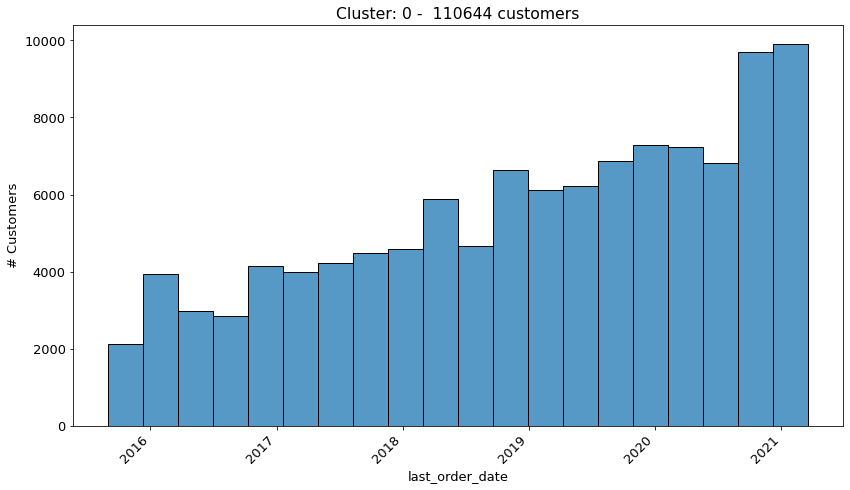

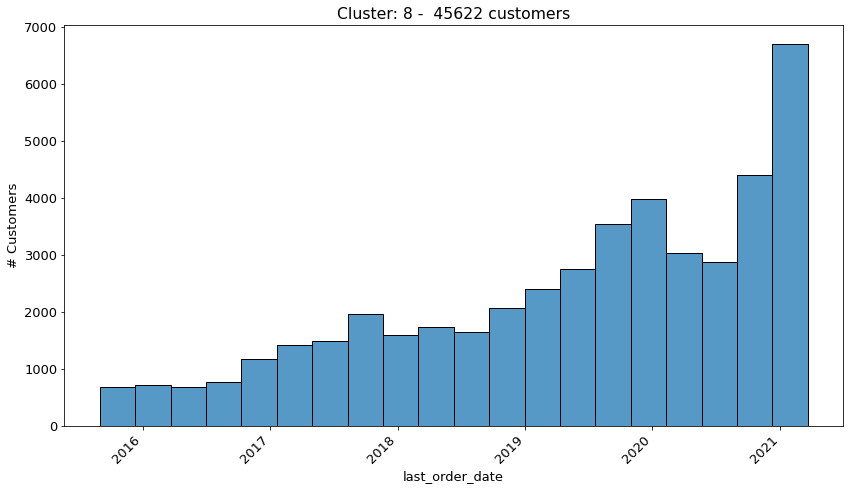

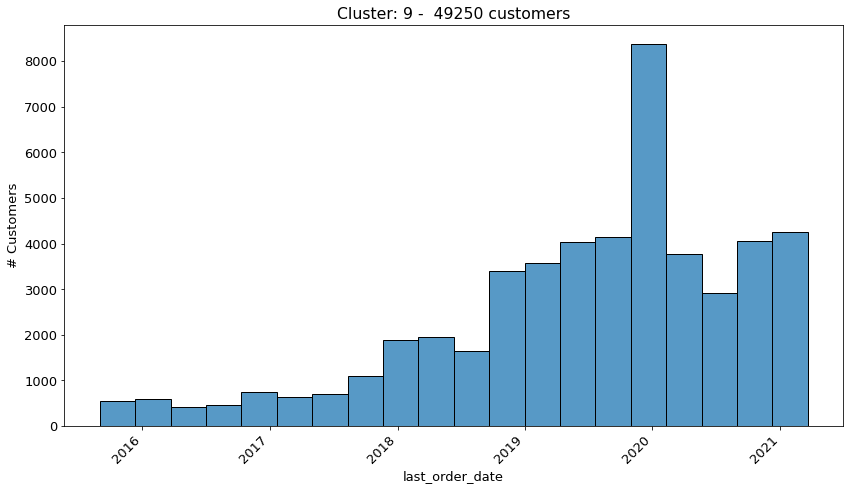

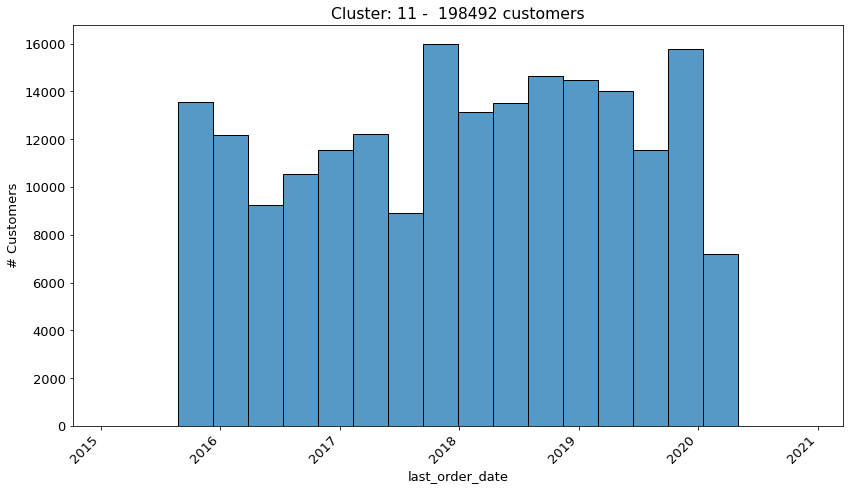

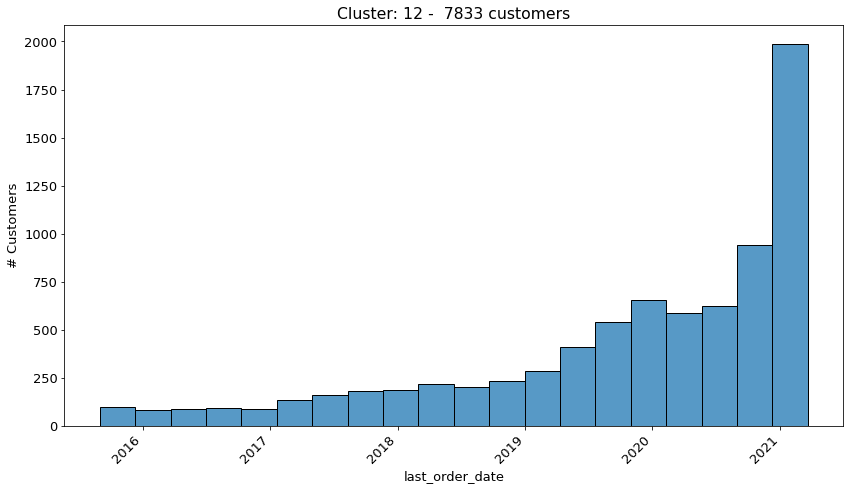

time: 3.1 s (started: 2021-07-13 12:08:24 -07:00)


In [19]:
labels = clusters
rfm_pre_covid['segments'] = labels
#labels = rfm_pre_covid_mapped_clusters['8'].values
for label in np.unique(labels):
   
    custs = rfm_pre_covid[rfm_pre_covid['segments']==label].shape[0]
    if custs < 100:
        continue
    fig,ax = plt.subplots(figsize=(12,7))
    sns.histplot(rfm_pre_covid[rfm_pre_covid['segments']==label]['last_order_date'], ax=ax, bins=20)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('# Customers')
    #plt.title('Last Order Date Cluster {} - {}'.format(label, custs))
    plt.title('Cluster: {} -  {} customers'.format(label, custs))
    plt.tight_layout()
    plt.show()

Cluster #8 has the distinctive dip after covid but still has active customers - this is the closest we can regenerate the old at-risk segment

## SCRATCH -  At risk revenue calcualtion

In [35]:
label = 8

time: 300 µs (started: 2021-06-08 08:46:26 -07:00)


In [52]:
at_risk_full = rfm_pre_covid[(rfm_pre_covid['segments']==label)]

time: 29.1 ms (started: 2021-06-08 08:56:19 -07:00)


In [72]:
at_risk_full['orders_per_year'].describe()

count   45622.00000
mean       12.04223
std        28.66189
min         0.00000
25%         0.00000
50%         2.82911
75%         7.11020
max       273.75000
Name: orders_per_year, dtype: float64

time: 7.52 ms (started: 2021-06-08 11:39:01 -07:00)


In [56]:
at_risk_full['dwr_aov_first_180_days'].mean() , at_risk_full['dwr_aov_after_first_180_days'].mean()

(3329.889496626206, 1377.187104931706)

time: 2.64 ms (started: 2021-06-08 08:56:43 -07:00)


In [63]:
(at_risk_full['dwr_rev_first_180_days'].sum() + 
 at_risk_full['hm_rev_first_180_days'].sum() +
 at_risk_full['hay_rev_first_180_days'].sum())/(at_risk_full['num_dwr_orders_first_180_days'].sum() +
                                               at_risk_full['num_hm_orders_first_180_days'].sum() +
                                               at_risk_full['num_hay_orders_first_180_days'].sum())

3156.314947069825

time: 3.01 ms (started: 2021-06-08 09:00:05 -07:00)


In [64]:
(at_risk_full['dwr_rev_after_first_180_days'].sum() + 
 at_risk_full['hm_rev_after_first_180_days'].sum() +
 at_risk_full['hay_rev_after_first_180_days'].sum())/(at_risk_full['num_dwr_orders_after_first_180_days'].sum() +
                                               at_risk_full['num_hm_orders_after_first_180_days'].sum() +
                                               at_risk_full['num_hay_orders_after_first_180_days'].sum())

2275.697005791929

time: 3.01 ms (started: 2021-06-08 09:00:47 -07:00)


In [62]:
at_risk_full['dwr_rev_after_first_180_days'].sum()

339443764.4177061

time: 2.11 ms (started: 2021-06-08 08:59:05 -07:00)


In [61]:
at_risk_full['num_dwr_orders_after_first_180_days'].sum()

145158

time: 1.82 ms (started: 2021-06-08 08:58:37 -07:00)


In [60]:
at_risk_full['dwr_rev_after_first_180_days'].sum()

339443764.4177061

time: 1.94 ms (started: 2021-06-08 08:58:22 -07:00)


In [36]:
at_risk = rfm_pre_covid[(rfm_pre_covid['segments']==label) & 
              (rfm_pre_covid['last_order_date'] > datetime.strptime('2018-01-01', '%Y-%m-%d')) &
              (rfm_pre_covid['last_order_date'] < datetime.strptime('2020-03-15', '%Y-%m-%d'))]

time: 28.9 ms (started: 2021-06-08 08:46:26 -07:00)


In [71]:
at_risk['nt_emails'].dropna().to_csv('at_risk_emails.csv', index=False)

time: 36.3 ms (started: 2021-06-08 09:43:00 -07:00)


In [45]:
at_risk2 = rfm_pre_covid[(rfm_pre_covid['segments']==label) & 
              (rfm_pre_covid['last_order_date'] > datetime.strptime('2019-01-01', '%Y-%m-%d')) &
              (rfm_pre_covid['last_order_date'] < datetime.strptime('2020-03-15', '%Y-%m-%d'))]

time: 19.2 ms (started: 2021-06-08 08:47:21 -07:00)


In [47]:
at_risk['aov'] = at_risk['total_revenue']/at_risk['num_orders']
at_risk2['aov'] = at_risk2['total_revenue']/at_risk2['num_orders']

time: 2.3 ms (started: 2021-06-08 08:47:47 -07:00)


<ipython-input-47-4f2f5e6ab354>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  at_risk['aov'] = at_risk['total_revenue']/at_risk['num_orders']
<ipython-input-47-4f2f5e6ab354>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  at_risk2['aov'] = at_risk2['total_revenue']/at_risk2['num_orders']


In [38]:
age = pd.to_datetime(at_risk['last_order']) - pd.to_datetime(at_risk['first_order'])

time: 13.9 ms (started: 2021-06-08 08:46:27 -07:00)


In [39]:
(age / np.timedelta64(1, 'D')).describe()

count   20647.00000
mean      313.34310
std       447.26451
min         0.00000
25%         0.00000
50%        42.00000
75%       545.50000
max      1686.00000
dtype: float64

time: 5.86 ms (started: 2021-06-08 08:46:27 -07:00)


In [40]:
at_risk['aov'].median(), at_risk.shape[0]

(2237.645, 20647)

time: 2.29 ms (started: 2021-06-08 08:46:27 -07:00)


In [41]:
email[email['email'].isin(at_risk['nt_emails'].dropna().unique())]

,email,first_send_date,first_engage_date,num_dwr_sends_first_180_days,num_hm_sends_first_180_days,num_hay_sends_first_180_days,num_dwr_opens_first_180_days,num_hm_opens_first_180_days,num_hay_opens_first_180_days,num_dwr_clicks_first_180_days,num_hm_clicks_first_180_days,num_hay_clicks_first_180_days,num_dwr_unsubs_first_180_days,num_hm_unsubs_first_180_days,num_hay_unsubs_first_180_days,num_dwr_spams_first_180_days,num_hm_spams_first_180_days,num_hay_spams_first_180_days,num_sale_sends_first_180_days,num_sale_opens_first_180_days,num_sale_clicks_first_180_days,num_evergreen_sends_first_180_days,num_evergreen_opens_first_180_days,num_evergreen_clicks_first_180_days,num_transactional_sends_first_180_days,num_transactional_opens_first_180_days,num_transactional_clicks_first_180_days,num_trigger_sends_first_180_days,num_trigger_opens_first_180_days,num_trigger_clicks_first_180_days,num_outlets_sends_first_180_days,num_outlets_opens_first_180_days,num_outlets_clicks_first_180_days,num_trade_sends_first_180_days,num_trade_opens_first_180_days,num_trade_clicks_first_180_days,num_contract_sends_first_180_days,num_contract_opens_first_180_days,num_contract_clicks_first_180_days,num_dwr_sends_after_first_180_days,num_hm_sends_after_first_180_days,num_hay_sends_after_first_180_days,num_dwr_opens_after_first_180_days,num_hm_opens_after_first_180_days,num_hay_opens_after_first_180_days,num_dwr_clicks_after_first_180_days,num_hm_clicks_after_first_180_days,num_hay_clicks_after_first_180_days,num_dwr_unsubs_after_first_180_days,num_hm_unsubs_after_first_180_days,...,dwr_unsub_rate_after_first_180_days,dwr_spam_rate_after_first_180_days,hm_open_rate_after_first_180_days,hm_click_rate_after_first_180_days,hm_unsub_rate_after_first_180_days,hm_spam_rate_after_first_180_days,hay_open_rate_after_first_180_days,hay_click_rate_after_first_180_days,hay_unsub_rate_after_first_180_days,hay_spam_rate_after_first_180_days,sale_open_rate_after_first_180_days,sale_click_rate_after_first_180_days,evergreen_open_rate_after_first_180_days,evergreen_click_rate_after_first_180_days,transactional_open_rate_after_first_180_days,transactional_click_rate_after_first_180_days,trigger_open_rate_after_first_180_days,trigger_click_rate_after_first_180_days,outlets_open_rate_after_first_180_days,outlets_click_rate_after_first_180_days,trade_open_rate_after_first_180_days,trade_click_rate_after_first_180_days,contract_open_rate_after_first_180_days,contract_click_rate_after_first_180_days,dwr_open_rate_before_purchase,dwr_click_rate_before_purchase,dwr_unsub_rate_before_purchase,dwr_spam_rate_before_purchase,hm_open_rate_before_purchase,hm_click_rate_before_purchase,hm_unsub_rate_before_purchase,hm_spam_rate_before_purchase,hay_open_rate_before_purchase,hay_click_rate_before_purchase,hay_unsub_rate_before_purchase,hay_spam_rate_before_purchase,sale_open_rate_before_purchase,sale_click_rate_before_purchase,evergreen_open_rate_before_purchase,evergreen_click_rate_before_purchase,transactional_open_rate_before_purchase,transactional_click_rate_before_purchase,trigger_open_rate_before_purchase,trigger_click_rate_before_purchase,outlets_open_rate_before_purchase,outlets_click_rate_before_purchase,trade_open_rate_before_purchase,trade_click_rate_before_purchase,contract_open_rate_before_purchase,contract_click_rate_before_purchas
32,afroman@delvinia.com,2018-10-11,2018-10-15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,74,0,0,42,0,0,16,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.55072,0.21739,0.00000,0.00000,0.75000,0.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
51,ardithmed@gmail.com,2017-03-12,2017-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

time: 133 ms (started: 2021-06-08 08:46:27 -07:00)


In [42]:
at_risk_email_sends = email[email['email'].isin(at_risk['nt_emails'].dropna().unique())][
    ['email', 'num_dwr_sends_first_180_days', 'num_hm_sends_first_180_days', 
     'num_hay_sends_first_180_days', 'num_dwr_sends_after_first_180_days', 'num_hm_sends_after_first_180_days', 
     'num_hay_sends_after_first_180_days']].set_index('email').sum(axis=1)

at_risk_email_clicks = email[email['email'].isin(at_risk['nt_emails'].dropna().unique())][
    ['email', 'num_dwr_clicks_first_180_days', 'num_hm_clicks_first_180_days', 
     'num_hay_clicks_first_180_days', 'num_dwr_clicks_after_first_180_days', 'num_hm_clicks_after_first_180_days', 
     'num_hay_clicks_after_first_180_days']].set_index('email').sum(axis=1)

time: 150 ms (started: 2021-06-08 08:46:36 -07:00)


In [43]:
at_risk_email_clicks.sum(), at_risk_email_sends.sum(), at_risk_email_clicks.sum()/at_risk_email_sends.sum()

(75018, 1641443, 0.045702470326414016)

time: 1.85 ms (started: 2021-06-08 08:46:36 -07:00)


In [66]:
(at_risk.shape[0], at_risk2.shape[0],  
 at_risk['total_revenue'].sum()/at_risk['num_orders'].sum(), 
 at_risk2['total_revenue'].sum()/at_risk2['num_orders'].sum())

(20647, 14221, 3010.8212544833564, 2871.8432271650477)

time: 2.95 ms (started: 2021-06-08 09:02:42 -07:00)


Assumptions
1. Customers in this group order almost 3 times a year. Thus, we only look at people who have ordered betwen 2019 and 2020 until covid. 

In [67]:
at_risk.shape[0]*(at_risk['total_revenue'].sum()/at_risk['num_orders'].sum())\
    *(at_risk_email_clicks.sum()/at_risk_email_sends.sum())*.25

710266.963698219

time: 2.61 ms (started: 2021-06-08 09:02:58 -07:00)


In [78]:
14221*2024.4725*.04*.23

264868.215487

time: 40.2 ms (started: 2021-06-07 21:17:52 -07:00)
